# Finetuning of ImageNet pretrained EfficientNet-B4 for Blindness Detection with PyTorch Ignite

Recently new ConvNets architectures have been proposed in ["EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks"](https://arxiv.org/pdf/1905.11946.pdf) paper. According to the paper, model's compound scaling starting from a 'good' baseline provides an network that achieves  state-of-the-art on  ImageNet,  while  being 8.4x  smaller and 6.1x faster on inference than the best existing ConvNet.

![efficientnets](https://raw.githubusercontent.com/pytorch/ignite/c22609796031f5831f054036895696c7e4df07ce/examples/notebooks/assets/efficientnets.png)

[Official implementation](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet) of EfficientNet uses Tensorflow, 
for our case we will borrow the code from [katsura-jp/efficientnet-pytorch](https://github.com/katsura-jp/efficientnet-pytorch), 
[rwightman/pytorch-image-models](https://github.com/rwightman/pytorch-image-models) and [lukemelas/EfficientNet-PyTorch](https://github.com/lukemelas/EfficientNet-PyTorch/) repositories (kudos to authors!). We will download pretrained weights from [lukemelas/EfficientNet-PyTorch](https://github.com/lukemelas/EfficientNet-PyTorch/) repository.

(sourced from [Ignite](https://github.com/pytorch/ignite/tree/master/examples))

## Network architecture review
The architecture of EfficientNet-B0 is the following:
```
1 - Stem    - Conv3x3|BN|Swish

2 - Blocks  - MBConv1, k3x3 
            - MBConv6, k3x3 repeated 2 times
            - MBConv6, k5x5 repeated 2 times
            - MBConv6, k3x3 repeated 3 times
            - MBConv6, k5x5 repeated 3 times
            - MBConv6, k5x5 repeated 4 times
            - MBConv6, k3x3
                            totally 16 blocks

3 - Head    - Conv1x1|BN|Swish 
            - Pooling
            - Dropout
            - FC
```

where 
```
Swish(x) = x * sigmoid(x)
```
and `MBConvX` stands for mobile inverted bottleneck convolution, X - denotes expansion ratio:
``` 
MBConv1 : 
  -> DepthwiseConv|BN|Swish -> SqueezeExcitation -> Conv|BN

MBConv6 : 
  -> Conv|BN|Swish -> DepthwiseConv|BN|Swish -> SqueezeExcitation -> Conv|BN

MBConv6+IdentitySkip : 
  -.-> Conv|BN|Swish -> DepthwiseConv|BN|Swish -> SqueezeExcitation -> Conv|BN-(+)->
   \___________________________________________________________________________/
```

In [1]:
def is_interactive():
   return 'runtime' in get_ipython().config.IPKernelApp.connection_file

print('Interactive?', is_interactive())

debug = is_interactive()
# debug = False

# use mixed float precision for training
use_amp = True
print(use_amp)

Interactive? False


In [2]:
import os, sys, gc
import numpy as np
import random
import torch
import ignite

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

In [3]:
torch.__version__, ignite.__version__

('1.1.0', '0.2.0')

In [4]:
%%time
if use_amp:
    try:
        from apex import amp
    except ImportError:
#         !git clone https://github.com/NVIDIA/apex
#         !pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" apex/
        !pip install  -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ../input/nvidiaapex/repository/NVIDIA-apex-39e153a
        from apex import amp

/opt/conda/lib/python3.6/site-packages/pip/_internal/commands/install.py:243: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-vp8dsvq5
Created temporary directory: /tmp/pip-req-tracker-6vriv72q
Created requirements tracker '/tmp/pip-req-tracker-6vriv72q'
Created temporary directory: /tmp/pip-install-vvypd5nn
Processing /kaggle/input/nvidiaapex/repository/NVIDIA-apex-39e153a
  Created temporary directory: /tmp/pip-req-build-qetki8ln
  Added file:///kaggle/input/nvidiaapex/repository/NVIDIA-apex-39e153a to build tracker '/tmp/pip-req-tracker-6vriv72q'
    Running setup.py (path:/tmp/pip-req-build-qetki8ln/setup.py) egg_info for package from file:///kaggle/input/nvidiaapex/repository/NVIDIA-apex-39e153a
    Running command python setup.py egg_info
    torch.__version__  =  1.1.0
    running egg_info
    creating pip-egg

## Model


Let's define some helpful modules:
- Flatten 
- Swish 

The reason why Swish is not implemented in `torch.nn` can be found [here](https://github.com/pytorch/pytorch/pull/3182).


In [5]:
import torch
import torch.nn as nn

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class Flatten(nn.Module):
    def forward(self, x):
        return x.reshape(x.shape[0], -1)

Let's visualize Swish transform vs ReLU:

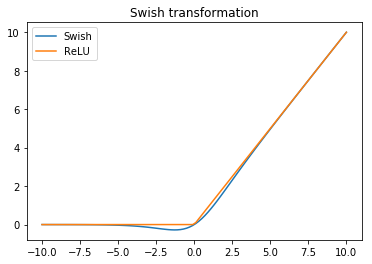

In [6]:
import matplotlib.pylab as plt
%matplotlib inline

d = torch.linspace(-10.0, 10.0)
s = Swish()
res = s(d)
res2 = torch.relu(d)

plt.title("Swish transformation")
plt.plot(d.numpy(), res.numpy(), label='Swish')
plt.plot(d.numpy(), res2.numpy(), label='ReLU')
plt.legend()

Now let's define `SqueezeExcitation` module

In [7]:
class SqueezeExcitation(nn.Module):
    
    def __init__(self, inplanes, se_planes):
        super(SqueezeExcitation, self).__init__()
        self.reduce_expand = nn.Sequential(
            nn.Conv2d(inplanes, se_planes, 
                      kernel_size=1, stride=1, padding=0, bias=True),
            Swish(),
            nn.Conv2d(se_planes, inplanes, 
                      kernel_size=1, stride=1, padding=0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        x_se = torch.mean(x, dim=(-2, -1), keepdim=True)
        x_se = self.reduce_expand(x_se)
        return x_se * x


Next, we can define `MBConv`.

**Note on implementation**: in Tensorflow (and PyTorch ports) convolutions use `SAME` padding option which in PyTorch requires
a specific padding computation and additional operation to apply. We will use built-in padding argument of the convolution.

In [8]:
from torch.nn import functional as F

class MBConv(nn.Module):
    def __init__(self, inplanes, planes, kernel_size, stride, 
                 expand_rate=1.0, se_rate=0.25, 
                 drop_connect_rate=0.2):
        super(MBConv, self).__init__()

        expand_planes = int(inplanes * expand_rate)
        se_planes = max(1, int(inplanes * se_rate))

        self.expansion_conv = None        
        if expand_rate > 1.0:
            self.expansion_conv = nn.Sequential(
                nn.Conv2d(inplanes, expand_planes, 
                          kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(expand_planes, momentum=0.01, eps=1e-3),
                Swish()
            )
            inplanes = expand_planes

        self.depthwise_conv = nn.Sequential(
            nn.Conv2d(inplanes, expand_planes,
                      kernel_size=kernel_size, stride=stride, 
                      padding=kernel_size // 2, groups=expand_planes,
                      bias=False),
            nn.BatchNorm2d(expand_planes, momentum=0.01, eps=1e-3),
            Swish()
        )

        self.squeeze_excitation = SqueezeExcitation(expand_planes, se_planes)
        
        self.project_conv = nn.Sequential(
            nn.Conv2d(expand_planes, planes, 
                      kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(planes, momentum=0.01, eps=1e-3),
        )

        self.with_skip = stride == 1
        self.drop_connect_rate = torch.tensor(drop_connect_rate, requires_grad=False)
    
    def _drop_connect(self, x):        
        keep_prob = 1.0 - self.drop_connect_rate
        drop_mask = torch.rand(x.shape[0], 1, 1, 1) + keep_prob
        drop_mask = drop_mask.type_as(x)
        drop_mask.floor_()
        return drop_mask * x / keep_prob
        
    def forward(self, x):
        z = x
        if self.expansion_conv is not None:
            x = self.expansion_conv(x)

        x = self.depthwise_conv(x)
        x = self.squeeze_excitation(x)
        x = self.project_conv(x)
        
        # Add identity skip
        if x.shape == z.shape and self.with_skip:            
            if self.training and self.drop_connect_rate is not None:
                self._drop_connect(x)
            x += z
        return x

And finally, we can implement generic `EfficientNet':

In [9]:
from collections import OrderedDict
import math


def init_weights(module):    
    if isinstance(module, nn.Conv2d):    
        nn.init.kaiming_normal_(module.weight, a=0, mode='fan_out')
    elif isinstance(module, nn.Linear):
        init_range = 1.0 / math.sqrt(module.weight.shape[1])
        nn.init.uniform_(module.weight, a=-init_range, b=init_range)
        
        
class EfficientNet(nn.Module):
        
    def _setup_repeats(self, num_repeats):
        return int(math.ceil(self.depth_coefficient * num_repeats))
    
    def _setup_channels(self, num_channels):
        num_channels *= self.width_coefficient
        new_num_channels = math.floor(num_channels / self.divisor + 0.5) * self.divisor
        new_num_channels = max(self.divisor, new_num_channels)
        if new_num_channels < 0.9 * num_channels:
            new_num_channels += self.divisor
        return new_num_channels

    def __init__(self, num_classes, 
                 width_coefficient=1.0,
                 depth_coefficient=1.0,
                 se_rate=0.25,
                 dropout_rate=0.2,
                 drop_connect_rate=0.2):
        super(EfficientNet, self).__init__()
        
        self.width_coefficient = width_coefficient
        self.depth_coefficient = depth_coefficient
        self.divisor = 8
                
        list_channels = [32, 16, 24, 40, 80, 112, 192, 320, 1280]
        list_channels = [self._setup_channels(c) for c in list_channels]
                
        list_num_repeats = [1, 2, 2, 3, 3, 4, 1]
        list_num_repeats = [self._setup_repeats(r) for r in list_num_repeats]        
        
        expand_rates = [1, 6, 6, 6, 6, 6, 6]
        strides = [1, 2, 2, 2, 1, 2, 1]
        kernel_sizes = [3, 3, 5, 3, 5, 5, 3]

        # Define stem:
        self.stem = nn.Sequential(
            nn.Conv2d(3, list_channels[0], kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(list_channels[0], momentum=0.01, eps=1e-3),
            Swish()
        )
        
        # Define MBConv blocks
        blocks = []
        counter = 0
        num_blocks = sum(list_num_repeats)
        for idx in range(7):
            
            num_channels = list_channels[idx]
            next_num_channels = list_channels[idx + 1]
            num_repeats = list_num_repeats[idx]
            expand_rate = expand_rates[idx]
            kernel_size = kernel_sizes[idx]
            stride = strides[idx]
            drop_rate = drop_connect_rate * counter / num_blocks
            
            name = "MBConv{}_{}".format(expand_rate, counter)
            blocks.append((
                name,
                MBConv(num_channels, next_num_channels, 
                       kernel_size=kernel_size, stride=stride, expand_rate=expand_rate, 
                       se_rate=se_rate, drop_connect_rate=drop_rate)
            ))
            counter += 1
            for i in range(1, num_repeats):                
                name = "MBConv{}_{}".format(expand_rate, counter)
                drop_rate = drop_connect_rate * counter / num_blocks                
                blocks.append((
                    name,
                    MBConv(next_num_channels, next_num_channels, 
                           kernel_size=kernel_size, stride=1, expand_rate=expand_rate, 
                           se_rate=se_rate, drop_connect_rate=drop_rate)                                    
                ))
                counter += 1
        
        self.blocks = nn.Sequential(OrderedDict(blocks))
        
        # Define head
        self.head = nn.Sequential(
            nn.Conv2d(list_channels[-2], list_channels[-1], 
                      kernel_size=1, bias=False),
            nn.BatchNorm2d(list_channels[-1], momentum=0.01, eps=1e-3),
            Swish(),
            nn.AdaptiveAvgPool2d(1),
            Flatten(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(list_channels[-1], num_classes)
        )

        self.apply(init_weights)
        
    def forward(self, x):
        f = self.stem(x)
        f = self.blocks(f)
        y = self.head(f)
        return y

**All EfficientNet models can be defined using the following parametrization:
```
# (width_coefficient, depth_coefficient, resolution, dropout_rate)
'efficientnet-b0': (1.0, 1.0, 224, 0.2),
'efficientnet-b1': (1.0, 1.1, 240, 0.2),
'efficientnet-b2': (1.1, 1.2, 260, 0.3),
'efficientnet-b3': (1.2, 1.4, 300, 0.3),
'efficientnet-b4': (1.4, 1.8, 380, 0.4),
'efficientnet-b5': (1.6, 2.2, 456, 0.4),
'efficientnet-b6': (1.8, 2.6, 528, 0.5),
'efficientnet-b7': (2.0, 3.1, 600, 0.5),
```    
Let's define and train the third last one: `EfficientNet-B4

In [10]:
model = EfficientNet(num_classes=1000, 
                     width_coefficient=1.4, depth_coefficient=1.8,
                     dropout_rate=0.4)
resolution = 380
img_stats  = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]

Number of parameters:

In [11]:
def print_num_params(model, display_all_modules=False):
    total_num_params = 0
    for n, p in model.named_parameters():
        num_params = 1
        for s in p.shape:
            num_params *= s
        if display_all_modules: print("{}: {}".format(n, num_params))
        total_num_params += num_params
    print("-" * 50)
    print("Total number of parameters: {:.2e}".format(total_num_params))
    

print_num_params(model)

--------------------------------------------------
Total number of parameters: 1.93e+07


Let's compare the number of parameters with some of ResNets:

In [12]:
from torchvision.models.resnet import resnet18, resnet34, resnet50

In [13]:
print_num_params(resnet18(pretrained=False, num_classes=1000))
print_num_params(resnet34(pretrained=False, num_classes=1000))
print_num_params(resnet50(pretrained=False, num_classes=1000))

--------------------------------------------------
Total number of parameters: 1.17e+07
--------------------------------------------------
Total number of parameters: 2.18e+07
--------------------------------------------------
Total number of parameters: 2.56e+07


### Model's graph with Tensorboard

We can optionally inspect model's graph with the code below. For that we need to install
`tensorboardX` package.
Otherwise go directly to the next section.

In [14]:
# from tensorboardX.pytorch_graph import graph

# import random
# from IPython.display import clear_output, Image, display, HTML


# def show_graph(graph_def):
#     """Visualize TensorFlow graph."""
#     if hasattr(graph_def, 'as_graph_def'):
#         graph_def = graph_def.as_graph_def()
#     strip_def = graph_def
#     code = """
#         <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
#         <script>
#           function load() {{
#             document.getElementById("{id}").pbtxt = {data};
#           }}
#         </script>
#         <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
#         <div style="height:600px">
#           <tf-graph-basic id="{id}"></tf-graph-basic>
#         </div>
#     """.format(data=repr(str(strip_def)), id='graph'+str(random.randint(0, 1000)))

#     iframe = """
#         <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
#     """.format(code.replace('"', '&quot;'))
#     display(HTML(iframe))

In [15]:
# x = torch.rand(4, 3, 224, 224)
# graph_def = graph(model, x, operator_export_type='RAW')

In [16]:
# Display in Firefox may not work properly. Use Chrome.
# show_graph(graph_def[0])

### Load pretrained weights

Let's load pretrained weights and check the model on a single image.

In [17]:
from collections import OrderedDict

model_state = torch.load("/kaggle/input/efficientnet-pytorch/efficientnet-b4-e116e8b3.pth")

# A basic remapping is required
mapping = {
    k: v for k, v in zip(model_state.keys(), model.state_dict().keys())
}
mapped_model_state = OrderedDict([
    (mapping[k], v) for k, v in model_state.items()
])

model.load_state_dict(mapped_model_state, strict=False)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

torch.Size([1, 3, 380, 380])


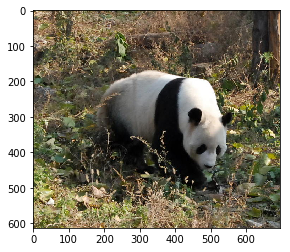

In [18]:
import json

with open("/kaggle/input/efficientnet-pytorch/efficientnet-pytorch/EfficientNet-PyTorch-master/examples/simple/labels_map.txt", "r") as h:
    labels = json.load(h)

from PIL import Image
import torchvision.transforms as transforms


img = Image.open("/kaggle/input/efficientnet-pytorch/efficientnet-pytorch/EfficientNet-PyTorch-master/examples/simple/img.jpg")
# Preprocess image
tfms = transforms.Compose([transforms.Resize([resolution]*2),
                           transforms.ToTensor(),
                           transforms.Normalize(*img_stats),])
x = tfms(img).unsqueeze(0)
print(x.shape)
_ = plt.imshow(img, shape=[resolution]*2)

In [19]:
# Classify
model.eval()
with torch.no_grad():
    y_pred = model(x)

# Print predictions
print('-----')
for idx in torch.topk(y_pred, k=5)[1].squeeze(0).tolist():
    prob = torch.softmax(y_pred, dim=1)[0, idx].item()
    print('{label:<75} ({p:.2f}%)'.format(label=labels[str(idx)], p=prob*100))

-----
giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca           (65.64%)
lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens         (0.56%)
American black bear, black bear, Ursus americanus, Euarctos americanus      (0.31%)
soccer ball                                                                 (0.23%)
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus                 (0.19%)


## Dataflow

Let's setup the dataflow:
- load train and test datasets
- setup train/test image transforms
- setup train/test data loaders

According to the paper authors borrowed training settings from other publications and the dataflow for CIFAR100 is the following:

- input images to the network during training are resized to the model resolution
- horizontally flipped randomly and augmented using cutout.
- each mini-batch contained 256 examples


In [20]:
from torchvision.transforms import *

from torch.utils.data import Subset
import torchvision.utils as vutils

import pandas as pd
from sklearn.utils import shuffle

class_weights: [0.21592525766263254, 1.053365108327167, 0.39013522530635814, 2.019404611818921, 1.3211697968849212]


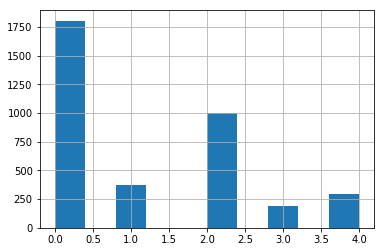

In [21]:
df_train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
df_test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

x = df_train['id_code']
y = df_train['diagnosis']

x, y = shuffle(x, y)
_ = y.hist()

# get class stats
n_classes = int(y.max()+1)
class_weights = len(y) / df_train.groupby('diagnosis').count().values.ravel()  # we can use this to balance our loss function
class_weights *= n_classes / class_weights.sum()
print('class_weights:', class_weights.tolist())

In [22]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(x.values, y.values, test_size=0.10, stratify=y, random_state=42)
test_x = df_test.id_code.values

if debug:
    train_x, train_y = train_x[:128], train_y[:128]
    valid_x, valid_y = valid_x[:64], valid_y[:64]

print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)
print(test_x.shape)

(3295,)
(3295,)
(367,)
(367,)
(1928,)


In [23]:
from PIL import Image

class ImageDataset(torch.utils.data.Dataset):

    def __init__(self, root, path_list, targets=None, transform=None, extension='.png'):
        super().__init__()
        self.root = root
        self.path_list = path_list
        self.targets = targets
        self.transform = transform
        self.extension = extension
        if targets is not None:
            assert len(self.path_list) == len(self.targets)
            self.targets = torch.LongTensor(targets)

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path = self.path_list[index]
        sample = Image.open(os.path.join(self.root, path+self.extension))
        if self.transform is not None:
            sample = self.transform(sample)

        if self.targets is not None:
            return sample, self.targets[index]
        else:
            return sample, torch.LongTensor([])

    def __len__(self):
        return len(self.path_list)

In [24]:
from PIL.Image import BICUBIC

train_transform = Compose([
    Resize([resolution]*2, BICUBIC),
    RandomAffine(degrees=180, translate=(0.01, 0.01), scale=(1.05, 1.25), fillcolor=(0,0,0), resample=BICUBIC),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    ToTensor(),
    Normalize(*img_stats)
])

test_transform = Compose([
    Resize([resolution]*2, BICUBIC),
    ToTensor(),
    Normalize(*img_stats)
])

train_dataset = ImageDataset(root='../input/aptos2019-blindness-detection/train_images',
                             path_list=train_x, targets=train_y, transform=train_transform)
train_eval_dataset = ImageDataset(root='../input/aptos2019-blindness-detection/train_images',
                                  path_list=valid_x, targets=valid_y, transform=test_transform)
test_dataset = ImageDataset(root='../input/aptos2019-blindness-detection/test_images',
                            path_list=test_x, transform=test_transform)

print(len(train_dataset), len(test_dataset), len(train_eval_dataset))

3295 1928 367


In [25]:
from torch.utils.data import DataLoader

train_batch_size = 32
eval_batch_size = 16  ## optimized for loading speed
num_workers = os.cpu_count()
print('num_workers:', num_workers)

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, num_workers=num_workers, 
                          shuffle=True, drop_last=True, pin_memory=True)

test_loader = DataLoader(test_dataset, batch_size=eval_batch_size, num_workers=num_workers, 
                         shuffle=False, drop_last=False, pin_memory=True)

eval_train_loader = DataLoader(train_eval_dataset, batch_size=eval_batch_size, num_workers=num_workers, 
                               shuffle=False, drop_last=False, pin_memory=True)

num_workers: 2


CPU times: user 4.48 s, sys: 1.05 s, total: 5.53 s
Wall time: 17.1 s


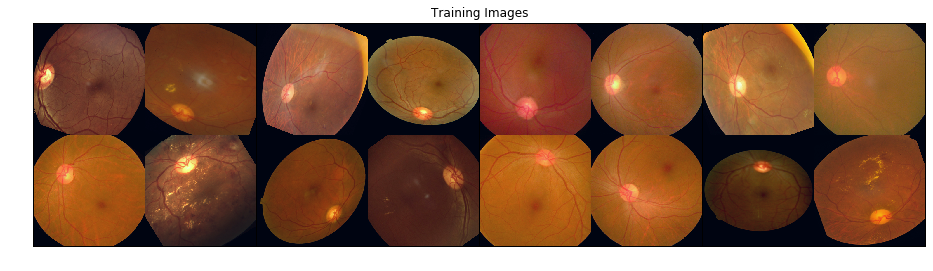

In [26]:
%%time
# Plot some training images
batch = next(iter(train_loader))

plt.figure(figsize=(16, 8))
plt.axis("off")
plt.title("Training Images")
_ = plt.imshow( 
    vutils.make_grid(batch[0][:16], padding=2, normalize=True).cpu().numpy().transpose((1, 2, 0))
)

In [27]:
{'mean':batch[0].mean(dim=(0,2,3)), 'std':batch[0].std(dim=(0,2,3))}

{'mean': tensor([-0.1144, -1.0115, -1.5335]),
 'std': tensor([1.0861, 0.5872, 0.2745])}

In [28]:
# Classify prior to fine tunning
model.eval()
with torch.no_grad():
    y_pred = model.cuda()(batch[0][:1].cuda())

# Print predictions
print('-----')
for idx in torch.topk(y_pred, k=5)[1].squeeze(0).tolist():
    prob = torch.softmax(y_pred, dim=1)[0, idx].item()
    print('{label:<75} ({p:.2f}%)'.format(label=labels[str(idx)], p=prob*100))

-----
nematode, nematode worm, roundworm                                          (34.53%)
shield, buckler                                                             (11.80%)
lampshade, lamp shade                                                       (7.37%)
tick                                                                        (5.83%)
jack-o'-lantern                                                             (3.71%)


In [29]:
del batch
torch.cuda.empty_cache()

## Finetunning model

As we are interested to finetune the model to APTOS19, we will replace the classification fully-connected layer (originally for ImageNet-1000).

In [30]:
in_features, out_features = model.head[6].in_features, model.head[6].out_features
in_features, out_features

(1792, 1000)

In [31]:
model.head[6] = nn.Linear(in_features, n_classes+1) # we want to train a regular 5 class classifier plus 1 kappa regressor
classes = ('No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR')

In [32]:
model.head[6].in_features, model.head[6].out_features

(1792, 6)

We will finetune the model on GPU with AMP fp32/fp16 using nvidia/apex package.

In [33]:
assert torch.cuda.is_available()
assert torch.backends.cudnn.enabled, "NVIDIA/Apex:Amp requires cudnn backend to be enabled."
torch.backends.cudnn.benchmark = True

device = "cuda"

In [34]:
model = model.to(device)

# Training

Let's setup Focal loss as criterion and SGD as optimizer.

We will split model parameters into 2 groups: 

    1) feature extractor (pretrained weights)
    2) classifier (random weights)

and define different learning rates for these groups (via learning rate scheduler).

In [35]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2., reduction='mean'):
        super().__init__()
        self.alpha = torch.tensor(alpha)
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        self.alpha = self.alpha.type(inputs.type(), non_blocking=True) # fix type and device

        CE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha[targets] * (1-pt)**self.gamma * CE_loss

        if self.reduction == 'sum':
            return F_loss.sum()
        elif self.reduction == 'mean':
            return F_loss.mean()
        return F_loss

In [36]:
# activation = lambda y: (n_classes-1) * torch.sigmoid(y)
activation = lambda y: (n_classes-1) * (0.5 + 0.5 * y / (1 + y.abs()))  # linear sigmoid

def cont_kappa(input, targets, activation=activation):
    ''' continuos version of quadratic weighted kappa '''
    pred = targets.float().unsqueeze(0)
    y = input.float().unsqueeze(0)
    if activation is not None:
        y = activation(y)
    n = y.shape[1]
    wo = (pred - y)**2
    we = (pred - y.t())**2
    return 1 - (n * wo.sum() / we.sum())
# adapted from keras version: https://www.kaggle.com/ryomiyazaki/keras-simple-implementation-of-qwk-for-regressor

In [37]:
kappa_loss = lambda y, pred: 1 - cont_kappa(y, pred)  # from 0 to 2 instead of 1 to -1

In [38]:
# test loss
y = torch.from_numpy(np.random.randint(5, size=6))
preds = (y.float()-2)*2.5  # closish to inverse activation
print(y.tolist())
print(preds.tolist())
print(activation(preds).tolist())
cont_kappa(y, preds), kappa_loss(y, preds)

[2, 4, 2, 0, 3, 2]
[0.0, 5.0, 0.0, -5.0, 2.5, 0.0]
[2.0, 3.6666665077209473, 2.0, 0.3333333730697632, 3.4285714626312256, 2.0]


(tensor(0.1709), tensor(0.8291))

In [39]:
# balance between metric optimisation and classification accuracy
class MultiTaskLoss(FocalLoss):
    def __init__(self, alpha=None, gamma=2.0, second_loss=kappa_loss, second_mult=0.15):
        super().__init__(alpha, gamma)
        self.second_loss = second_loss
        self.second_mult = second_mult

    def forward(self, inputs, targets):
        loss  = super().forward(inputs[...,:-1], targets)  # focal loss
        loss += self.second_mult * self.second_loss(inputs[...,-1], targets)
        return loss

In [40]:
from itertools import chain

import torch.optim as optim
import torch.nn.functional as F

criterion = MultiTaskLoss(gamma=3., alpha=class_weights)
lr = 0.05  # placeholder only! check the LR schedulers below

optimizer = optim.SGD([
    {
        "params": chain(model.stem.parameters(), model.blocks.parameters()),
        "lr": lr * 0.1,
    },
    {
        "params": model.head[:6].parameters(),
        "lr": lr * 0.2,
    },    
    {
        "params": model.head[6].parameters(), 
        "lr": lr
    }], 
    momentum=0.9, weight_decay=1e-2, nesterov=True)

In [41]:
if use_amp:
    # Initialize Amp
    model, optimizer = amp.initialize(model, optimizer, opt_level="O2", num_losses=1)

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


Next, let's define a single iteration function `update_fn`. This function is then used by `ignite.engine.Engine` to update model while running over the input data.

In [42]:
from ignite.utils import convert_tensor


def update_fn(engine, batch):
    x = convert_tensor(batch[0], device=device, non_blocking=True)
    y = convert_tensor(batch[1], device=device, non_blocking=True)

    model.train()
    y_pred = model(x)

    # Compute loss 
    loss = criterion(y_pred, y)

    optimizer.zero_grad()
    if use_amp:
        with amp.scale_loss(loss, optimizer, loss_id=0) as scaled_loss:
            scaled_loss.backward()
    else:
        loss.backward()
    optimizer.step()

    return {
        "batchloss": loss.item(),
    }

Let's check `update_fn`

In [43]:
torch.cuda.empty_cache()
_ = gc.collect()

try:
    batch = next(iter(train_loader))
    res = update_fn(engine=None, batch=batch)
    print(res)
finally:
    del batch
    torch.cuda.empty_cache()
    _ = gc.collect()

{'batchloss': 0.5866479277610779}


Now let's define a trainer and add some practical handlers:
- log to tensorboard: losses, metrics, lr
- progress bar
- models/optimizers checkpointing

In [44]:
from ignite.engine import Engine, Events, create_supervised_evaluator
from ignite.metrics import RunningAverage, Accuracy, Precision, Recall, Loss, TopKCategoricalAccuracy

from ignite.contrib.handlers import TensorboardLogger
from ignite.contrib.handlers.tensorboard_logger import OutputHandler, OptimizerParamsHandler

In [45]:
from sklearn.metrics import cohen_kappa_score

def qw_kappa(pred, y):  ## quadratic weights
    return cohen_kappa_score(torch.argmax(pred[...,:-1], dim=1).cpu().numpy(),
                             y.cpu().numpy(),
                             weights='quadratic')

trainer = Engine(update_fn)

metrics = {
    'Loss': Loss(criterion),
#     'Accuracy': Accuracy(),
#     'Precision': Precision(average=True),
#     'Recall': Recall(average=True),
    'ClKappa': Loss(qw_kappa),
    'RgKappa': Loss(lambda pred, y: cont_kappa(y, pred[...,-1].squeeze())),
}

evaluator = create_supervised_evaluator(model, metrics=metrics, device=device, non_blocking=True)

class Metrics(RunningAverage):
    def __init__(self, evaluator, output_transform=None):
        super().__init__(alpha=0.9, output_transform=output_transform)
        self._evaluator = evaluator
        self.validation_history = {}
        self.loss_history = []

    def attach(self, engine, name):
        super().attach(engine, name)
        engine.add_event_handler(Events.EPOCH_COMPLETED, self.run_evaluation)
        
    def compute(self):
        loss = super().compute()
        self.loss_history.append(loss)
        return loss

    def run_evaluation(self, engine=None):
        self._evaluator.run(eval_train_loader)
        # save validation_history
        for k,v in self._evaluator.state.metrics.items():
            if k not in self.validation_history.keys():
                self.validation_history[k] = [v]
            else:
                self.validation_history[k].append(v)

history = Metrics(evaluator, output_transform=lambda out: out['batchloss'])
history.attach(trainer, "batchloss")

In [46]:
from datetime import datetime

log_path = "./log"
tb_logger = TensorboardLogger(log_dir=log_path)

tb_logger.attach(trainer, 
                 log_handler=OutputHandler('training', ['batchloss', ]), 
                 event_name=Events.ITERATION_COMPLETED)

# Learning rate scheduling with warm restarts

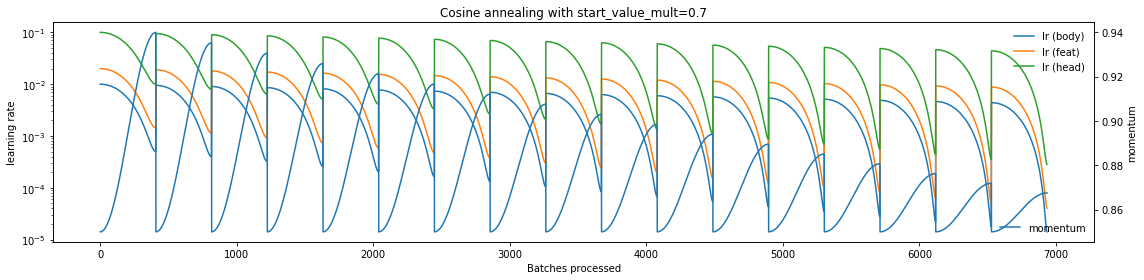

In [47]:
from ignite.contrib.handlers import CosineAnnealingScheduler, LinearCyclicalScheduler, ParamGroupScheduler

cycle_mult = 1
lr_sched_params = {'param_name':'lr', 'cycle_size':len(train_loader)*4, 'cycle_mult':cycle_mult,
                   'start_value_mult':0.95, 'end_value_mult':0.8}
mom_sched_params = {'param_name':'momentum', 'cycle_size':len(train_loader)*4, 'cycle_mult':cycle_mult,
                    'start_value':0.85, 'end_value':0.94, 'start_value_mult':1.0, 'end_value_mult':0.995}

lr = 0.1
body_sched_params = {**lr_sched_params, 'start_value':lr/10, 'end_value':lr/200}
body_sched = CosineAnnealingScheduler(optimizer.param_groups[0], **body_sched_params)
feat_sched_params = {**lr_sched_params, 'start_value':lr/5, 'end_value':lr/70}
feat_sched = CosineAnnealingScheduler(optimizer.param_groups[1], **feat_sched_params)
head_sched_params = {**lr_sched_params, 'start_value':lr, 'end_value':lr/10}
head_sched = CosineAnnealingScheduler(optimizer.param_groups[2], **feat_sched_params)

mom_sched = CosineAnnealingScheduler(optimizer, **mom_sched_params)
schedulers = [body_sched, feat_sched, head_sched, mom_sched]
names = ["lr (body)", "lr (feat)", "lr (head)", "momentum"]

sim_epochs = 68
lr_values0 = np.array(body_sched.simulate_values(num_events=len(train_loader)*sim_epochs, **body_sched_params))
lr_values1 = np.array(feat_sched.simulate_values(num_events=len(train_loader)*sim_epochs, **feat_sched_params))
lr_values2 = np.array(head_sched.simulate_values(num_events=len(train_loader)*sim_epochs, **head_sched_params))
mom_values = np.array(mom_sched.simulate_values(num_events=len(train_loader)*sim_epochs, **mom_sched_params))

fig = plt.figure(figsize=(16, 4))
ax = plt.subplot()
plt.title("Cosine annealing with start_value_mult=0.7")
ax.plot(lr_values0[:, 0], lr_values0[:, 1], label=names[0])
ax.plot(lr_values1[:, 0], lr_values1[:, 1], label=names[1])
ax.plot(lr_values2[:, 0], lr_values2[:, 1], label=names[2])
ax.set_yscale('log')
ax.set_xlabel('Batches processed')
ax.set_ylabel("learning rate")
ax.legend(frameon=False, loc='upper right')
ax2 = ax.twinx()
ax2.plot(mom_values[:, 0], mom_values[:, 1], label=names[3])
ax2.set_ylabel("momentum")
ax2.legend(frameon=False, loc='lower right')
fig.tight_layout()
_ = ax.plot()

In [48]:
# Log optimizer parameters
tb_logger.attach(trainer,
                 log_handler=OptimizerParamsHandler(optimizer, "lr"), 
                 event_name=Events.EPOCH_STARTED)

In [49]:
from ignite.contrib.handlers import ProgressBar

# Iteration-wise progress bar
pbar = ProgressBar(bar_format="")
pbar.attach(trainer, metric_names=['batchloss',])

# Epoch-wise progress bar with display of training losses
ProgressBar(persist=True, bar_format="").attach(trainer,
                                                event_name=Events.EPOCH_STARTED,
                                                closing_event_name=Events.COMPLETED)

/opt/conda/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


Let's create two evaluators to compute metrics on train/test images and log them to Tensorboard:

In [50]:
# Log validation metrics:
tb_logger.attach(evaluator,
                 log_handler=OutputHandler(tag="test",
                                           metric_names=list(metrics.keys()),
                                           another_engine=trainer),
                 event_name=Events.EPOCH_COMPLETED)

Now let's setup logging and the best model checkpointing:

In [51]:
import logging

# Setup engine &  logger
def setup_logger(logger):
    handler = logging.StreamHandler()
    formatter = logging.Formatter("%(asctime)s %(name)-12s %(levelname)-8s %(message)s")
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    logger.setLevel(logging.INFO)

In [52]:
from ignite.handlers import ModelCheckpoint, EarlyStopping, TerminateOnNan

trainer.add_event_handler(Events.ITERATION_COMPLETED, TerminateOnNan())

# Store the best model
def default_score_fn(engine):
    score = engine.state.metrics['RgKappa']
    return score

best_model_handler = ModelCheckpoint(dirname=log_path,
                                     filename_prefix="best",
                                     n_saved=10,
                                     score_name="RgKappa",
                                     score_function=default_score_fn,
                                     require_empty=False)
evaluator.add_event_handler(Events.COMPLETED, best_model_handler, {'model': model, })

# # Add early stopping
# es_patience = 15
# es_handler = EarlyStopping(patience=es_patience, score_function=default_score_fn, trainer=trainer)
# evaluator.add_event_handler(Events.EPOCH_COMPLETED, es_handler)
# setup_logger(es_handler._logger)

# Clear cuda cache between training/testing
@trainer.on(Events.EPOCH_COMPLETED)
@evaluator.on(Events.COMPLETED)
def empty_cuda_cache(engine):
    torch.cuda.empty_cache()
    import gc
    gc.collect()

Let's freeze the first layers for the first epochs 

In [53]:
@trainer.on(Events.EPOCH_STARTED)
def turn_on_layers(engine):
    epoch = engine.state.epoch
    if epoch == 1:
        for name, child in model.named_children():
            if name == 'head':
                pbar.log_message(f'"{name}" is unfrozen')
                for param in child.parameters():
                    param.requires_grad = True
            else:
                pbar.log_message(f'"{name}" is frozen')
                for param in child.parameters():
                    param.requires_grad = False
    if epoch == 3:
        pbar.log_message(f"Epoch {epoch}: Turn on all the layers")
        for name, child in model.named_children():
            for param in child.parameters():
                param.requires_grad = True

BatchNorm momentum scheduler

In [54]:
def collect_bn_modules(module, bn_modules):
    if isinstance(module, torch.nn.modules.batchnorm._BatchNorm):
        bn_modules.append(module)

bn_modules = []
model.apply(lambda module: collect_bn_modules(module, bn_modules))

bn_modules
@trainer.on(Events.EPOCH_STARTED)
def tweak_bn_momenta(engine):
    epoch = engine.state.epoch
    if epoch <= 12:
        momentum = 0.06 / epoch
        pbar.log_message(f"Epoch {epoch}: setting bn momentum {momentum}")
        for module in bn_modules:
            module.momentum = momentum

In [55]:
num_epochs = 5 if debug else sim_epochs

state = trainer.run(train_loader, max_epochs=num_epochs)

"stem" is frozen
"blocks" is frozen
"head" is unfrozen
Epoch 1: setting bn momentum 0.06


Epoch 2: setting bn momentum 0.03


Epoch 3: Turn on all the layers
Epoch 3: setting bn momentum 0.02


Epoch 4: setting bn momentum 0.015


Epoch 5: setting bn momentum 0.012


Epoch 6: setting bn momentum 0.01


Epoch 7: setting bn momentum 0.008571428571428572


Epoch 8: setting bn momentum 0.0075


Epoch 9: setting bn momentum 0.006666666666666666


Epoch 10: setting bn momentum 0.006


Epoch 11: setting bn momentum 0.005454545454545454


Epoch 12: setting bn momentum 0.005


Results on the validation set:

In [56]:
evaluator.state.metrics

{'Loss': 0.42133617717823474,
 'ClKappa': 0.5619363387884065,
 'RgKappa': 0.13430398394041554}

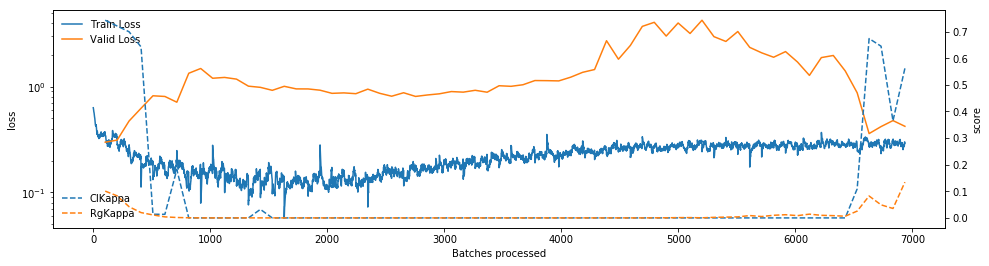

In [57]:
plt.figure(figsize=(16, 4))
ax = plt.subplot()
ax.set_yscale('log')
ax.set_xlabel('Batches processed')
ax.set_ylabel("loss")
ax.plot(history.loss_history, label='Train Loss')
ax2 = ax.twinx()
ax2.set_ylabel("score")
for k,v in history.validation_history.items():
    iters = np.arange(1, len(v)+1) * len(train_loader)
    if k == 'Loss':
          ax.plot(iters, v, label='Valid Loss')
    else: ax2.plot(iters, v, label=k, ls='--')
ax.legend(frameon=False, loc='upper left')
ax2.legend(frameon=False, loc='lower left')
_ = ax.plot()

In [58]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow
    https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/8#post_10'''
    from matplotlib.lines import Line2D
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.figure(figsize=(16, 12))
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

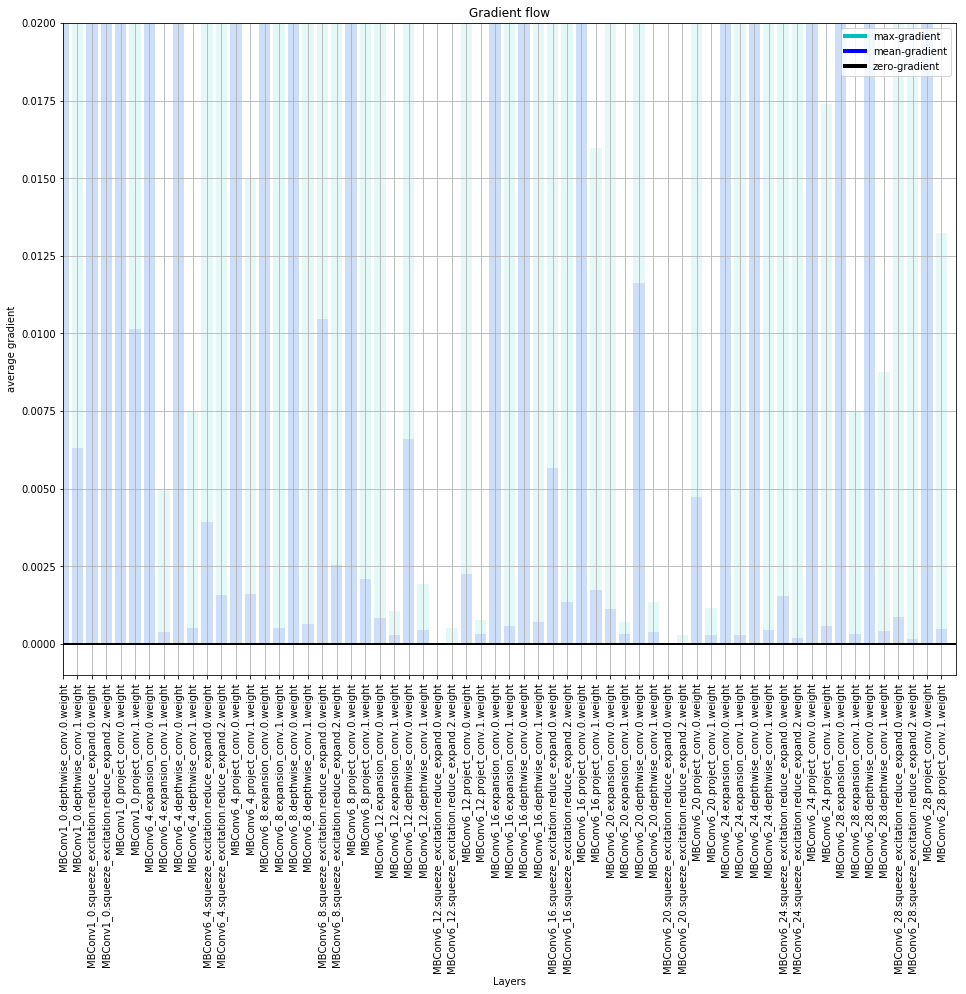

In [59]:
# check gradients on every 4 feature blocks (last batch)
plot_grad_flow(model.blocks[::4].named_parameters())

In [60]:
# # Load the TensorBoard notebook extension
# %load_ext tensorboard.notebook
# %tensorboard --logdir {log_path}

# Inference

Let's load the best model and recompute evaluation metrics on test dataset with a very basic Test-Time-Augmentation to boost the performances.


In [61]:
# Find the last checkpoint
!ls {log_path}
checkpoints = next(os.walk(log_path))[2]
checkpoints = sorted(filter(lambda f: f.endswith(".pth"), checkpoints))
scores = [c.split('=')[-1][:-4] for c in checkpoints]  # look for '*Metric=score.pth'
best_epoch = np.argmax(scores)
print(best_epoch, scores)
if not checkpoints:
    print('No weight files in {}'.format(log_path))
else:
    model_path = f'efficientNet_{scores[best_epoch]}.pth'
    !cp {os.path.join(log_path, checkpoints[best_epoch])} {model_path}

print(model_path)
!rm {log_path}/*.pth

best_model_1_RgKappa=0.1007114.pth
best_model_2_RgKappa=0.08285375.pth
best_model_3_RgKappa=0.0420419.pth
best_model_4_RgKappa=0.02005052.pth
best_model_60_RgKappa=0.01412375.pth
best_model_64_RgKappa=0.02561931.pth
best_model_65_RgKappa=0.08228578.pth
best_model_66_RgKappa=0.04911539.pth
best_model_67_RgKappa=0.03544511.pth
best_model_68_RgKappa=0.134304.pth
events.out.tfevents.1564869880.cbce3f6501f9
9 ['0.1007114', '0.08285375', '0.0420419', '0.02005052', '0.01412375', '0.02561931', '0.08228578', '0.04911539', '0.03544511', '0.134304']
efficientNet_0.134304.pth


In [62]:
best_model = model
best_model.load_state_dict(torch.load(model_path))
best_model = best_model.cuda()

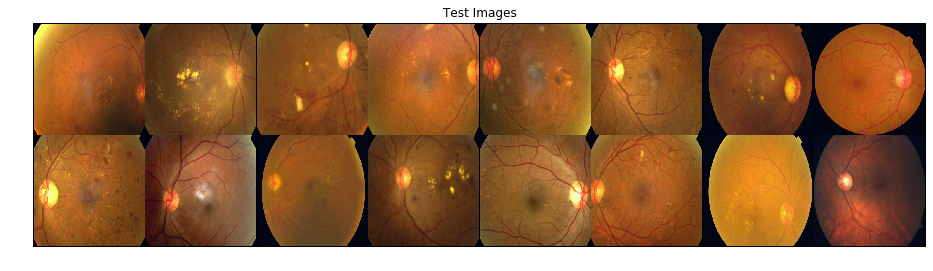

In [63]:
# Plot some test images
batch = next(iter(test_loader))

plt.figure(figsize=(16, 8))
plt.axis("off")
plt.title("Test Images")
_ = plt.imshow(
    vutils.make_grid(batch[0][:16], padding=2, normalize=True).cpu().numpy().transpose((1, 2, 0))
)

In [64]:
# Classify
best_model.eval()
with torch.no_grad():
    y_pred = best_model(batch[0][:16].cuda())[...,:-1]

print('activations:', activation(y_pred[:16,-1]))

# Print predictions for first item
for idx in torch.topk(y_pred[0], k=n_classes)[1].squeeze(0).tolist():
    prob = torch.softmax(y_pred, dim=-1)[0, idx].item()
    print('{label:<75} ({p:.2f}%)'.format(label=classes[idx], p=prob*100))

activations: tensor([2.4291, 3.1715, 3.1207, 2.5997, 3.1795, 3.2059, 3.0443, 1.9491, 3.3389,
        2.7466, 2.9112, 3.2646, 3.0044, 3.1778, 2.9272, 1.8674],
       device='cuda:0')
Moderate                                                                    (27.48%)
Severe                                                                      (23.91%)
Proliferative DR                                                            (23.75%)
Mild                                                                        (18.01%)
No DR                                                                       (6.85%)


#### Create submission

In [65]:
use_regressor = True

def inference_update_with_tta(engine, batch, use_regressor=use_regressor):
    global preds, targets
    best_model.eval()
    with torch.no_grad():
        x, y = batch
        x = x.cuda()
        # Let's compute final prediction as a mean of predictions on x and flipped x
        if use_regressor:
            y_pred1 = best_model(x)[...,-1]
            y_pred2 = best_model(x.flip(dims=(-1, )))[...,-1]
            # calc softmax for submission
            curr_pred = (activation(y_pred1) + activation(y_pred2)) * 0.5
            preds += curr_pred.cpu().squeeze().tolist()
        else:
            y_pred1 = best_model(x)[...,:-1]
            y_pred2 = best_model(x.flip(dims=(-1, )))[...,:-1]
            # calc softmax for submission
            curr_pred = F.softmax(y_pred1, dim=-1) + F.softmax(y_pred2, dim=-1)
            preds += curr_pred.argmax(dim=-1).cpu().squeeze().tolist()
        targets += y.cpu().squeeze().tolist()
        return y_pred1, y

inferencer = Engine(inference_update_with_tta)
ProgressBar(desc="Inference").attach(inferencer)

In [66]:
preds, targets = [], []
result_state = inferencer.run(eval_train_loader, max_epochs=1)

In [67]:
%%time
import scipy as sp

class KappaOptimizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.coef = [0.5, 1.5, 2.5, 3.4]
        # define score function:
        self.func = self.quad_kappa
    
    def predict(self, preds):
        return self._predict(self.coef, preds)

    @classmethod
    def _predict(cls, coef, preds):
        if type(preds).__name__ == 'Tensor':
            y_hat = preds.clone().view(-1)
        else:
            y_hat = torch.FloatTensor(preds).view(-1)

        for i,pred in enumerate(y_hat):
            if   pred < coef[0]: y_hat[i] = 0
            elif pred < coef[1]: y_hat[i] = 1
            elif pred < coef[2]: y_hat[i] = 2
            elif pred < coef[3]: y_hat[i] = 3
            else:                y_hat[i] = 4
        return y_hat.int()
    
    def quad_kappa(self, preds, y):
        return self._quad_kappa(self.coef, preds, y)

    @classmethod
    def _quad_kappa(cls, coef, preds, y):
        y_hat = cls._predict(coef, preds)
        return cohen_kappa_score(y, y_hat, weights='quadratic')

    def fit(self, preds, y):
        ''' maximize quad_kappa '''
        print('Early score:', self.quad_kappa(preds, y))
        neg_kappa = lambda coef: -self._quad_kappa(coef, preds, y)
        opt_res = sp.optimize.minimize(neg_kappa, x0=self.coef, method='nelder-mead',
                                       options={'maxiter':200, 'fatol':1e-20, 'xatol':1e-20})
        print(opt_res)
        self.coef = opt_res.x
        print('New score:', self.quad_kappa(preds, y))

    def forward(self, preds, y):
        ''' the pytorch loss function '''
        return torch.tensor(self.quad_kappa(preds, y))

kappa_opt = KappaOptimizer()
# fit on validation set
kappa_opt.fit(preds, targets)
opt_preds = kappa_opt.predict(preds).tolist()

Early score: 0.5605968697959619
 final_simplex: (array([[0.33172263, 2.0869853 , 3.06154927, 3.18939935],
       [0.33172263, 2.0869853 , 3.06154927, 3.18939935],
       [0.33172263, 2.0869853 , 3.06154927, 3.18939935],
       [0.33172263, 2.0869853 , 3.06154927, 3.18939935],
       [0.33172263, 2.0869853 , 3.06154927, 3.18939935]]), array([-0.65070389, -0.65070389, -0.65070389, -0.65070389, -0.65070389]))
           fun: -0.6507038869715072
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 1064
           nit: 200
        status: 2
       success: False
             x: array([0.33172263, 2.0869853 , 3.06154927, 3.18939935])
New score: 0.6507038869715072
CPU times: user 9.35 s, sys: 956 ms, total: 10.3 s
Wall time: 10.3 s


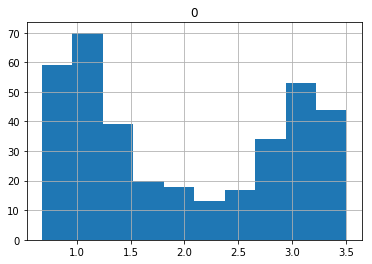

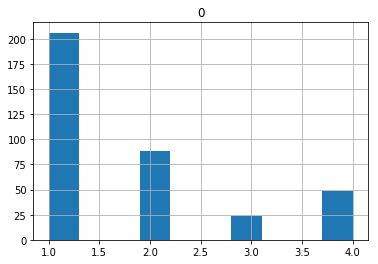

In [68]:
_ = pd.DataFrame(preds).hist()
_ = pd.DataFrame(opt_preds).hist()

In [69]:
preds, targets = [], []
result_state = inferencer.run(eval_train_loader, max_epochs=1)

Finally, the submission csv:

In [70]:
submission = pd.DataFrame({'id_code': pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv').id_code.values,
                          'diagnosis':np.squeeze(preds).astype(int)})

submission.hist()
submission.head()

ValueError: arrays must all be same length

In [71]:
submission.to_csv('submission.csv', index=False)

NameError: name 'submission' is not defined

In [72]:
# clean up folders
!rm -rf apex /tmp/*
!ls *

__notebook__.ipynb  __output__.json  efficientNet_0.134304.pth

log:
events.out.tfevents.1564869880.cbce3f6501f9


Submission in https://www.kaggle.com/hmendonca/efficientnet-pytorch-ignite-aptos19-submission